### Set up water network model

In this example, we test our quantum solvers into a slightly larger network as contained in `Net0.inp`. Let's start by setting up the model:|

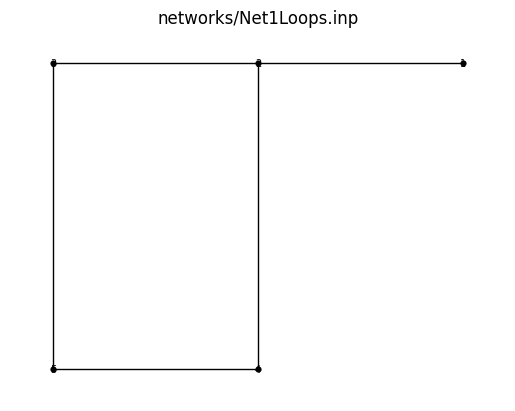

<Axes: title={'center': 'networks/Net1Loops.inp'}>

In [3]:
import os
import wntr
import wntr_quantum

os.environ["EPANET_TMP"] = "/home/nico/.epanet_quantum"
os.environ["EPANET_QUANTUM"] = "/home/nico/QuantumApplicationLab/vitens/EPANET"

# set up network model
inp_file = 'networks/Net1Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

# print options
# dict(wn.options.hydraulic)

### Solve model using the classical Epanet simulator

We now solve the same problem using the classical Epanet simulator. Note that, by default, `QuantumEpanetSimulator` uses a classical `CholeskySolver` to iteratively solve the linear problem.

In [4]:
import sys

# define the classical EPANET simulator
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)

# run the EPANET simulation
results_epanet = sim.run_sim()

# remember to set up EPANET Quantum environment variables!
epanet_path = os.environ["EPANET_QUANTUM"]
epanet_tmp = os.environ["EPANET_TMP"]

# check paths
print(f"Your EPANET quantum path: {epanet_path}")
print(f"Your EPANET temp dir: {epanet_tmp}\n")

util_path = os.path.join(epanet_path, 'src/py/')
sys.path.append(util_path)

from quantum_linsolve import load_json_data
epanet_A, epanet_b = load_json_data(os.path.join(epanet_tmp,'smat.json'))

# set the size of the Jacobian (A matrix)
epanet_A_dim = epanet_A.todense().shape[0]
print(f"Size of the Jacobian in EPANET simulator: {epanet_A_dim}")
print(f"Size of the b vector in EPANET simulator: {epanet_b.shape[0]}")

# save number of nodes and pipes
n_nodes = len(results_epanet.node["pressure"].iloc[0]), 
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["flowrate"]

/home/nico/QuantumApplicationLab/vitens/wntr-quantum/wntr_quantum/epanet/Linux/libepanet22_amd64.so
Your EPANET quantum path: /home/nico/QuantumApplicationLab/vitens/EPANET
Your EPANET temp dir: /home/nico/.epanet_quantum

Size of the Jacobian in EPANET simulator: 4
Size of the b vector in EPANET simulator: 4


(name          2          3          4          5             1
 0     57.939995  31.496479  52.434612  21.174667  4.394531e-07,
 name         1         2         3         4         5
 0     0.163867  0.059455  0.076645  0.043315  0.031685)

### Define a helper function

Before proceeding to the proper quantum solution of the water network model, let's define a helper function. This function checks that the quantum results are within `TOL`% of those obtained classically. It also fills in lists containing the final values of pressures and flow rates obtained.

In [5]:
TOL = 50  # => per cent
DELTA = 1.0e-12


def get_ape_from_pd_series(quantum_pd_series, classical_pd_series):
    """Helper function to evaluate absolute percentage error between classical and quantum results."""
    ape = abs(quantum_pd_series - classical_pd_series) * 100.0 / abs(classical_pd_series + DELTA)
    return ape


def compare_results(classical_result, quantum_result):
    """
    Helper function that compares the classical and quantum simulation results.
    """
    classical_data = []
    quantum_data = []

    def check_ape(classical_value, quantum_value):
        """Helper function to check if the absolute percentage error between classical and quantum results is within TOL."""
        ape = abs(quantum_value - classical_value) * 100.0 / abs(classical_value + DELTA)
        is_close_to_classical = ape <= TOL
        if is_close_to_classical:
            print(f"Quantum result {quantum_value} within {ape}% of classical result {classical_value}")
            quantum_data.append(quantum_value)
            classical_data.append(classical_value)
        return is_close_to_classical

    for link in classical_result.link["flowrate"].columns:
        classical_value = classical_result.link["flowrate"][link].iloc[0]
        quantum_value = quantum_result.link["flowrate"][link].iloc[0]
        message = f"Flowrate {link}: {quantum_value} not within {TOL}% of classical result {classical_value}"
        assert check_ape(classical_value, quantum_value), message

    for node in classical_result.node["pressure"].columns:
        classical_value = classical_result.node["pressure"][node].iloc[0]
        quantum_value = quantum_result.node["pressure"][node].iloc[0]
        message = f"Pressure {node}: {quantum_value} not within {TOL}% of classical result {classical_value}"
        assert check_ape(classical_value, quantum_value), message

    return classical_data, quantum_data

### Solve water network with `QuantumEpanetSimulator` and VQLS 

We now solve the model using VQLS. In this example, we are **preconditioning** the initial linear system using *diagonal scaling* and also using a **mix of two classical optimizers**.

In [6]:
import numpy as np
from qiskit.primitives import Estimator
from quantum_newton_raphson.hhl_solver import HHL_SOLVER

n_qubits = int(np.ceil(np.log2(epanet_A_dim)))
estimator = Estimator()

linear_solver = HHL_SOLVER(
    estimator=estimator,
    # preconditioner="diagonal_scaling",
)

sim = wntr_quantum.sim.QuantumEpanetSimulator(wn, linear_solver=linear_solver)
results_hhl= sim.run_sim(linear_solver=linear_solver)

classical_res, quantum_res = compare_results(results_epanet, results_hhl)

results_hhl.node["pressure"], results_hhl.link["flowrate"]

/home/nico/QuantumApplicationLab/vitens/wntr-quantum/wntr_quantum/epanet/Linux/libepanet22_amd64.so
Quantum result 0.1623460203409195 within 0.9281053240305208% of classical result 0.16386687755584717
Quantum result 0.05410035699605942 within 9.006576108687334% of classical result 0.05945523828268051
Quantum result 0.08046545088291168 within 4.984521429924255% of classical result 0.07664506137371063
Quantum result 0.044026244431734085 within 1.6423844658899842% of classical result 0.043314848095178604
Quantum result 0.034720078110694885 within 9.578156839629255% of classical result 0.03168521821498871
Quantum result 58.00852966308594 within 0.11828591165149603% of classical result 57.93999481201172
Quantum result 34.20833206176758 within 8.61001962911399% of classical result 31.496479034423828
Quantum result 52.49580001831055 within 0.11669342345984283% of classical result 52.43461227416992
Quantum result 20.140758514404297 within 4.882763098443745% of classical result 21.1746673583984

(name         2          3        4          5             1
 0     58.00853  34.208332  52.4958  20.140759  4.394531e-07,
 name         1       2         3         4        5
 0     0.162346  0.0541  0.080465  0.044026  0.03472)

### Plot pressures and flow rates

Let's check graphically the equivalence of the results.

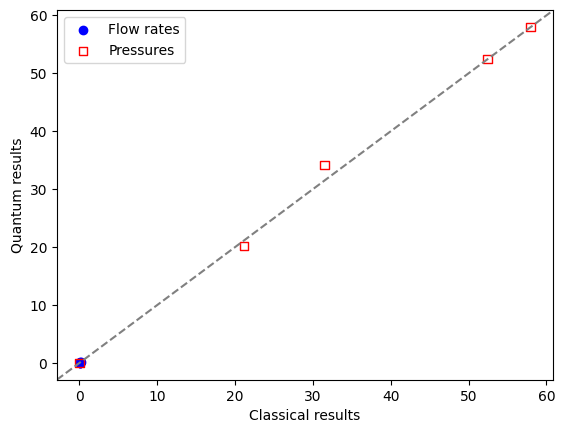

In [7]:
import matplotlib.pyplot as plt
plt.scatter(classical_res[:n_pipes], quantum_res[:n_pipes], label="Flow rates", color="blue", marker="o")
plt.scatter(classical_res[n_pipes:], quantum_res[n_pipes:], label="Pressures", color="red", marker="s", facecolors='none')
plt.axline((0, 0), slope=1, linestyle="--", color="gray", label="")
plt.xlabel("Classical results")
plt.ylabel("Quantum results")
plt.legend()
plt.show()

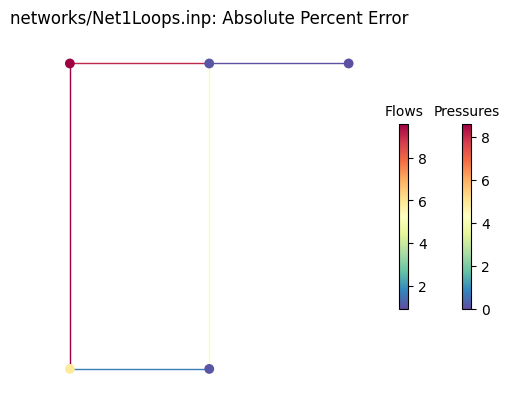

<Axes: title={'center': 'networks/Net1Loops.inp: Absolute Percent Error'}>

In [8]:
wntr.graphics.plot_network(
    wn,
    node_attribute=get_ape_from_pd_series(
        results_hhl.node["pressure"].iloc[0],
        results_epanet.node["pressure"].iloc[0]
    ),
    link_attribute=get_ape_from_pd_series(
        results_hhl.link["flowrate"].iloc[0],
        results_epanet.link["flowrate"].iloc[0],
    ),
    node_colorbar_label='Pressures',
    link_colorbar_label='Flows',
    node_size=50,
    title=f"{inp_file}: Absolute Percent Error",
    node_labels=False
)